In [1]:
# Data processing
import iris
import numpy as np
import xarray as xr
import timeit
import dateutil.parser
import warnings
warnings.filterwarnings('ignore', module='iris')
from iris.experimental import stratify
from iris.analysis import trajectory
from pathlib import Path
from datetime import datetime, timedelta
# Visualization
import matplotlib.pyplot as plt
## Scientific parameters
M_air = 28.97 # molar mass of dry air [kg]
# Coefficients to convert mass mixing ratio to volume mixing ratio
coeff_c2h6 = (M_air/30.0690)*1e12
coeff_c3h8 = (M_air/44.0956)*1e12
coeff_nc4h10 = (M_air/58.1222)*1e12
coeff_ic4h10 = (M_air/58.1222)*1e12
coeff_nc5h12 = (M_air/72.1488)*1e12
coeff_ic5h12 = (M_air/72.1488)*1e12
coeff_meono2 = (M_air/77.0394)*1e12
coeff_sbuono2 = (M_air/119.1192)*1e12
coeff_n2peono2 = (M_air/133.1457)*1e12
coeff_n3peono2 = (M_air/133.1457)*1e12
coeff_ipeono2 = (M_air/133.1457)*1e12

#### Read data

In [2]:
path_to_atom = Path('../../external_data/ATom/nc/data')
# Select flights
flist_atom_flights = ['MER-WAS_DC8_20170218_R8.nc', 'MER-WAS_DC8_20170219_R7.nc', 'MER-WAS_DC8_20170221_R8.nc']
fpaths_atom_flights = [path_to_atom / i for i in flist_atom_flights]
# Read ATom data
atom_dsinf = xr.open_mfdataset(fpaths_atom_flights, decode_times=True)
atom_dsmms = xr.open_mfdataset(fpaths_atom_flights, group='MMS', decode_cf=True)
atom_dswas = xr.open_mfdataset(fpaths_atom_flights, group='WAS', decode_cf=True)

In [3]:
# Choose UKCA run parameters
ukca_run_name = 'ba897'; ukca_run_freq = 'T1H'; ukca_run_mnth = '201702'; levs = 'plevs'

path_to_ukca = Path('../data') / ukca_run_name
fname_ukca_run = f'{ukca_run_name}_{ukca_run_freq}_{ukca_run_mnth}_{levs}.nc'
# Read UKCA data
# cb_c2h6 = iris.load_cube(str(path_to_ukca / fname_ukca_run)+'alkanes.nc', 'C2H6 MASS MIXING RATIO AFTER TSTEP')*coeff_c2h6
# cb_c3h8 = iris.load_cube(str(path_to_ukca / fname_ukca_run)+'alkanes.nc', 'C3H8 MASS MIXING RATIO AFTER TSTEP')*coeff_c3h8
_cb_nc4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n-C4H10 MASS MIX RATIO ON PRESS LEVS')*coeff_nc4h10
_cb_ic4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'i-C4H10 MASS MIX RATIO ON PRESS LEVS')*coeff_ic4h10
_cb_nc5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n-C5H12 MASS MIX RATIO ON PRESS LEVS')*coeff_nc5h12
_cb_ic5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'i-C5H12 MASS MIX RATIO ON PRESS LEVS')*coeff_ic5h12
# cb_meono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run)+'nitrates.nc', 'MeONO2 MASS MIXING RATIO AFTER TSTEP')*coeff_meono2
_cb_sbuono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 's-BuONO2 MMR ON PRESSURE LEVS')*coeff_sbuono2
_cb_n2peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n-2PeONO2 MMR ON PRESSURE LEVS')*coeff_n2peono2
_cb_n3peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n-3PeONO2 MMR ON PRESSURE LEVS')*coeff_n3peono2
_cb_ipeono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'i-PeONO2 MMR ON PRESSURE LEVS')*coeff_ipeono2
# Extract certain longitude range
cb_nc4h10 = _cb_nc4h10.extract(iris.Constraint(longitude=lambda cell: 199.6875 <= cell <= 351.5625))
cb_ic4h10 = _cb_ic4h10.extract(iris.Constraint(longitude=lambda cell: 199.6875 <= cell <= 351.5625))
cb_nc5h12 = _cb_nc5h12.extract(iris.Constraint(longitude=lambda cell: 199.6875 <= cell <= 351.5625))
cb_ic5h12 = _cb_ic5h12.extract(iris.Constraint(longitude=lambda cell: 199.6875 <= cell <= 351.5625))
cb_sbuono2 = _cb_sbuono2.extract(iris.Constraint(longitude=lambda cell: 199.6875 <= cell <= 351.5625))
cb_n2peono2 = _cb_n2peono2.extract(iris.Constraint(longitude=lambda cell: 199.6875 <= cell <= 351.5625))
cb_n3peono2 = _cb_n3peono2.extract(iris.Constraint(longitude=lambda cell: 199.6875 <= cell <= 351.5625))
cb_ipeono2 = _cb_ipeono2.extract(iris.Constraint(longitude=lambda cell: 199.6875 <= cell <= 351.5625))
# Load altitude coordinate of UKCA's global domain
_alt_coord = iris.load_cube(str(Path('../data')/'ukca_coords_n96e_marcus_180705.nc'),'mass_fraction_of_ozone_in_air').coord('altitude')

In [4]:
# Extract datetimes from ATom and UKCA data
atom_datetime = atom_dsinf.time.values.astype('<M8[us]').astype(datetime)
atom_date_strt = atom_datetime[0]
atom_date_stop = atom_datetime[-1]
ukca_days_since = dateutil.parser.parse(str(cb_nc4h10.coord('t').units)[11:])
_ukca_datetime = []
for i, ii in enumerate(list(cb_nc4h10.coord('t').points)):
    _ukca_datetime.append(ukca_days_since + timedelta(days=float(f'{ii:1.3f}'))) # UKCA's 'days since 1960-09-01' format is 1.3f
ukca_datetime = np.array(_ukca_datetime, dtype=datetime)
# Create a common timestamp/flight merge identifier for trajectories
compared_common_id = f'{atom_date_strt.strftime("%y%m%d")}_{atom_date_stop.strftime("%y%m%d")}_{ukca_datetime[0].strftime("%y%m")}_merge_plev'
print(compared_common_id)

170218_170221_1702_merge_plev


##### 2. Calculate trajectories

In [11]:
# Reconstruct a flight trajectory from ATom geospacial and datetime data
sample_time = np.array([(i - ukca_days_since).total_seconds() / 86400. for i in atom_datetime])
sample_lats = atom_dsmms.G_LAT.data 
sample_lons = atom_dsmms.G_LONG.data+360
sample_plvs = atom_dsmms.P.data # [hPa] and cube.coord('Pressure') units mbar
sample_time_lats_lons_plvs = [('t', sample_time), ('latitude', sample_lats), ('longitude', sample_lons), ('Pressure', sample_plvs)]

In [26]:
start_time = timeit.default_timer()
# Interpolate releveled model data to flight trajectory
# traj_c2h6 = trajectory.interpolate(cb_c2h6, sample_time_lats_lons_plvs)
# traj_c3h8 = trajectory.interpolate(cb_c3h8, sample_time_lats_lons_plvs)
# traj_nc4h10 = trajectory.interpolate(cb_nc4h10, sample_time_lats_lons_plvs)
traj_ic4h10 = trajectory.interpolate(cb_ic4h10, sample_time_lats_lons_plvs)
# traj_nc5h12 = trajectory.interpolate(cb_nc5h12, sample_time_lats_lons_plvs)
# traj_ic5h12 = trajectory.interpolate(cb_ic5h12, sample_time_lats_lons_plvs)
# # traj_meono2 = trajectory.interpolate(cb_meono2, sample_time_lats_lons_plvs)
# traj_sbuono2 = trajectory.interpolate(cb_sbuono2, sample_time_lats_lons_plvs)
# traj_n2peono2 = trajectory.interpolate(cb_n2peono2, sample_time_lats_lons_plvs)
# traj_n3peono2 = trajectory.interpolate(cb_n3peono2, sample_time_lats_lons_plvs)
# traj_ipeono2 = trajectory.interpolate(cb_ipeono2, sample_time_lats_lons_plvs)
elapsed = timeit.default_timer() - start_time
elapsed/60

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


1.7631189332166666

##### 3. Extract cross sections

In [27]:
# Extract a cross section from model data along flight track
sample_time_lats_lons = [('t', sample_time), ('latitude', sample_lats), ('longitude', sample_lons)]
# crsc_c2h6 = trajectory.interpolate(cb_c2h6, sample_time_lats_lons)
# crsc_c3h8 = trajectory.interpolate(cb_c3h8, sample_time_lats_lons)
# crsc_nc4h10 = trajectory.interpolate(cb_nc4h10, sample_time_lats_lons)
crsc_ic4h10 = trajectory.interpolate(cb_ic4h10, sample_time_lats_lons)
# crsc_nc5h12 = trajectory.interpolate(cb_nc5h12, sample_time_lats_lons)
# crsc_ic5h12 = trajectory.interpolate(cb_ic5h12, sample_time_lats_lons)
# # crsc_meono2 = trajectory.interpolate(cb_meono2, sample_time_lats_lons)
# crsc_sbuono2 = trajectory.interpolate(cb_sbuono2, sample_time_lats_lons)
# crsc_n2peono2 = trajectory.interpolate(cb_n2peono2, sample_time_lats_lons)
# crsc_n3peono2 = trajectory.interpolate(cb_n3peono2, sample_time_lats_lons)
# crsc_ipeono2 = trajectory.interpolate(cb_ipeono2, sample_time_lats_lons)

#### Save processed data

In [15]:
path_to_prcd = Path('../processed') / ukca_run_name

In [28]:
# Save trajectories to .nc
# iris.save(traj_nc4h10, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_traj_nc4h10.nc')
iris.save(traj_ic4h10, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_traj_ic4h10.nc')
# iris.save(traj_nc5h12, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_traj_nc5h12.nc')
# iris.save(traj_ic5h12, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_traj_ic5h12.nc')
# iris.save(traj_sbuono2, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_traj_sbuono2.nc')
# iris.save(traj_n2peono2, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_traj_n2peono2.nc')
# iris.save(traj_n3peono2, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_traj_n3peono2.nc')
# iris.save(traj_ipeono2, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_traj_ipeono2.nc')

In [29]:
# Save cross sections to .nc
# iris.save(crsc_nc4h10, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_crsc_nc4h10.nc')
iris.save(crsc_ic4h10, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_crsc_ic4h10.nc')
# iris.save(crsc_nc5h12, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_crsc_nc5h12.nc')
# iris.save(crsc_ic5h12, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_crsc_ic5h12.nc')
# iris.save(crsc_sbuono2, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_crsc_sbuono2.nc')
# iris.save(crsc_n2peono2, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_crsc_n2peono2.nc')
# iris.save(crsc_n3peono2, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_crsc_n3peono2.nc')
# iris.save(crsc_ipeono2, str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_plvs_crsc_ipeono2.nc')

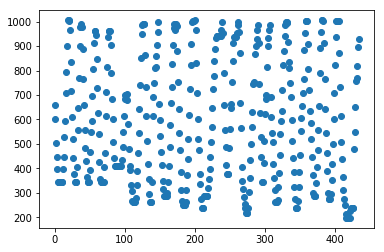

In [36]:
plt.scatter(np.arange(0,435), atom_dsmms.P.data);